In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ="/Users/jianan/Downloads/inf560/inf560.json"


In [596]:
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost
import lightgbm as lgb
import sklearn
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import log_loss,make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import gpxpy.geo
import numpy as np
import datetime


In [23]:
import pandas as pd 
dateparse = lambda x:pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') 
path = "T2_L1000000000001.csv"
df= pd.read_csv(path)
df = df[df['Role'] == 'P']
df.Lat.apply(lambda x : round(x,6))
df.Lng.apply(lambda x : round(x,6))
df['Time'] = df["Time"].str.split('.',expand = True)[0].str.split(' ',expand = True)[1]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923391 entries, 0 to 7204926
Data columns (total 13 columns):
Building    object
Level       object
MacId       object
Lat         float64
Lng         float64
Time        object
Yrmo        float64
Moday       float64
Yrday       int64
staff       float64
Role        object
Fly_Cat     object
Month       int64
dtypes: float64(5), int64(2), object(6)
memory usage: 419.1+ MB


# feature: time_bin ( To which 10min intravel the record belongs to)

In [24]:
def timebin(t):
    h,m,s = t.split(':')
    return int((int(h)*60 + int(m))/10)

df['bin'] = df['Time'].apply(timebin)
df.head()

Building    Level              MacId        Lat        Lng      Time  Yrmo  \
0     TPS2  Level 1  c0:17:4d:eb:3b:a7 -22.814858 -43.246001  20:59:53   NaN   
1     TPS2  Level 1  38:80:df:7b:75:5e -22.814024 -43.247071  02:41:06   NaN   
2     TPS2  Level 1  a4:70:d6:13:cd:61 -22.815134 -43.246403  07:13:42   NaN   
3     TPS2  Level 1  c0:b6:58:59:ec:94 -22.815245 -43.246433  15:31:03   NaN   
4     TPS2  Level 1  c0:8c:71:2c:21:43 -22.814127 -43.246390  01:22:34   NaN   

   Moday  Yrday  staff Role Fly_Cat  Month  bin  
0    NaN    302    NaN    P      OF     10   41  
1    NaN    359    NaN    P      FF     12    5  
2    NaN    251    NaN    P      OF      9   14  
3    NaN    274    NaN    P      OF     10   31  
4    NaN    312    NaN    P      OF     11    2

# feature : day of week 

In [25]:
# test['Time'] = pd.to_datetime(test['Time'],infer_datetime_format= True)
def dayofweek(yrday):
    return (datetime.datetime(2019, 1, 1) + datetime.timedelta(yrday - 1)).weekday()
df['drweek'] = df['Yrday'].apply(dayofweek)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923391 entries, 0 to 7204926
Data columns (total 15 columns):
Building    object
Level       object
MacId       object
Lat         float64
Lng         float64
Time        object
Yrmo        float64
Moday       float64
Yrday       int64
staff       float64
Role        object
Fly_Cat     object
Month       int64
bin         int64
drweek      int64
dtypes: float64(5), int64(4), object(6)
memory usage: 478.9+ MB


Building    Level              MacId        Lat        Lng      Time  Yrmo  \
0     TPS2  Level 1  c0:17:4d:eb:3b:a7 -22.814858 -43.246001  20:59:53   NaN   
1     TPS2  Level 1  38:80:df:7b:75:5e -22.814024 -43.247071  02:41:06   NaN   
2     TPS2  Level 1  a4:70:d6:13:cd:61 -22.815134 -43.246403  07:13:42   NaN   
3     TPS2  Level 1  c0:b6:58:59:ec:94 -22.815245 -43.246433  15:31:03   NaN   
4     TPS2  Level 1  c0:8c:71:2c:21:43 -22.814127 -43.246390  01:22:34   NaN   

   Moday  Yrday  staff Role Fly_Cat  Month  bin  drweek  
0    NaN    302    NaN    P      OF     10   41       1  
1    NaN    359    NaN    P      FF     12    5       2  
2    NaN    251    NaN    P      OF      9   14       6  
3    NaN    274    NaN    P      OF     10   31       1  
4    NaN    312    NaN    P      OF     11    2       4

In [26]:
df = df.drop(['Building','Level','staff','Yrmo','Moday','Role'],axis = True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923391 entries, 0 to 7204926
Data columns (total 9 columns):
MacId      object
Lat        float64
Lng        float64
Time       object
Yrday      int64
Fly_Cat    object
Month      int64
bin        int64
drweek     int64
dtypes: float64(2), int64(4), object(3)
memory usage: 299.3+ MB


MacId        Lat        Lng      Time  Yrday Fly_Cat  Month  \
0  c0:17:4d:eb:3b:a7 -22.814858 -43.246001  20:59:53    302      OF     10   
1  38:80:df:7b:75:5e -22.814024 -43.247071  02:41:06    359      FF     12   
2  a4:70:d6:13:cd:61 -22.815134 -43.246403  07:13:42    251      OF      9   
3  c0:b6:58:59:ec:94 -22.815245 -43.246433  15:31:03    274      OF     10   
4  c0:8c:71:2c:21:43 -22.814127 -43.246390  01:22:34    312      OF     11   

   bin  drweek  
0   41       1  
1    5       2  
2   14       6  
3   31       1  
4    2       4

In [593]:
location = []
with open('tsp2_l1.csv','r') as f:
    for line in f.readlines():
        location.append(line.strip().split(','))
location[0]
shop = [x[1:] for x in location if x[0] == 'shop']
eat = [x[1:] for x in location if x[0] == 'eat']
shop = [[float(i) for i in x] for x in shop]
eat = [[float(i) for i in x] for x in eat]
shop = list(map(lambda l : list(zip(l[::2], l[1::2])),shop))
eat = list(map(lambda l : list(zip(l[::2], l[1::2])),eat))
for x in eat:
    x.append(x[0])
for x in shop:
    x.append(x[0])


In [7]:

def c_within(x):
    
    for i in shop_polys:
        if x.within(i):
            return 1
    for i in eat_polys:
        if x.within(i):
            return 2
        
    return 0

from shapely.geometry import Point, Polygon
import geopandas
shop_polys = geopandas.GeoSeries([ Polygon(x) for x in shop ])
eat_polys = geopandas.GeoSeries([ Polygon(x) for x in eat ])
import shapely.ops as so

# 1. Label data by shop and restaurant Polygon

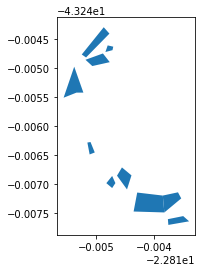

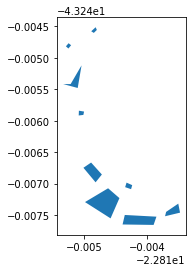

In [8]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
patches = []
num_polygons = 19
num_sides = 19

for i in range(num_polygons):
    polygon = Polygon(np.random.rand(num_sides ,2), True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)

plt.show()

shop_polys.plot()
eat_polys.plot()

In [28]:
geodf = geopandas.GeoDataFrame(df,geometry = geopandas.points_from_xy(df.Lat,df.Lng))

In [29]:
geodf['Tag'] = geodf.geometry.apply(c_within)
geodf.info()
geodf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3923391 entries, 0 to 7204926
Data columns (total 11 columns):
MacId       object
Lat         float64
Lng         float64
Time        object
Yrday       int64
Fly_Cat     object
Month       int64
bin         int64
drweek      int64
geometry    geometry
Tag         int64
dtypes: float64(2), geometry(1), int64(5), object(3)
memory usage: 359.2+ MB


MacId        Lat        Lng      Time  Yrday Fly_Cat  Month  \
0  c0:17:4d:eb:3b:a7 -22.814858 -43.246001  20:59:53    302      OF     10   
1  38:80:df:7b:75:5e -22.814024 -43.247071  02:41:06    359      FF     12   
2  a4:70:d6:13:cd:61 -22.815134 -43.246403  07:13:42    251      OF      9   
3  c0:b6:58:59:ec:94 -22.815245 -43.246433  15:31:03    274      OF     10   
4  c0:8c:71:2c:21:43 -22.814127 -43.246390  01:22:34    312      OF     11   

   bin  drweek                     geometry  Tag  
0   41       1  POINT (-22.81486 -43.24600)    0  
1    5       2  POINT (-22.81402 -43.24707)    0  
2   14       6  POINT (-22.81513 -43.24640)    0  
3   31       1  POINT (-22.81524 -43.24643)    0  
4    2       4  POINT (-22.81413 -43.24639)    0

In [30]:
df2 = pd.DataFrame(geodf.drop(columns = 'geometry'))
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3923391 entries, 0 to 7204926
Data columns (total 10 columns):
MacId      object
Lat        float64
Lng        float64
Time       object
Yrday      int64
Fly_Cat    object
Month      int64
bin        int64
drweek     int64
Tag        int64
dtypes: float64(2), int64(5), object(3)
memory usage: 329.3+ MB


MacId        Lat        Lng      Time  Yrday Fly_Cat  Month  \
0  c0:17:4d:eb:3b:a7 -22.814858 -43.246001  20:59:53    302      OF     10   
1  38:80:df:7b:75:5e -22.814024 -43.247071  02:41:06    359      FF     12   
2  a4:70:d6:13:cd:61 -22.815134 -43.246403  07:13:42    251      OF      9   
3  c0:b6:58:59:ec:94 -22.815245 -43.246433  15:31:03    274      OF     10   
4  c0:8c:71:2c:21:43 -22.814127 -43.246390  01:22:34    312      OF     11   

   bin  drweek  Tag  
0   41       1    0  
1    5       2    0  
2   14       6    0  
3   31       1    0  
4    2       4    0

In [31]:
print(len(df2[df2['Tag'] == 0])/len(df2))
print(len(df2[df2['Tag'] == 1])/len(df2))
print(len(df2[df2['Tag'] == 2])/len(df2))

0.7952105716712915
0.16793788842356014
0.036851539905148376


# method 1 result in classes imbalance
# 2. Label behavior based on radius(10 meters)

In [ ]:
def tag(lat,lng):
    mindis = 1000
    t = ''
    for l in location:
        distance = gpxpy.geo.haversine_distance(lat,lng,l[1], l[2])
        if mindis > distance:
            mindis = distance
            category = l[0]
    if mindis < 10:
        if category == 'eat':
            return 0
        if category == 'shop':
            return 1
    return 2
    


In [ ]:
location = pd.read_csv('tag.csv')
location.info()
location = location.values
df2['Tag'] = df.apply(lambda x:tag(x.Lat,x.Lng),axis = 1)



### classes more balanced 

In [95]:
print('eating,shopping,watitng')
print(len(df2[df2['Tag'] == 0])/len(df2))
print(len(df2[df2['Tag'] == 1])/len(df2))
print(len(df2[df2['Tag'] == 2])/len(df2))

eating,shopping,watitng
0.19021428774453944
0.3061513735035646
0.503634338751896


In [32]:
df8 = df2[df2['Month'] == 8]
df9 = df2[df2['Month'] == 9]
df10 = df2[df2['Month'] == 10]
df11 = df2[df2['Month'] == 11]
df12 = df2[df2['Month'] == 12]

df8.to_csv('8.csv',mode = 'a', header = False,index = False)

df9.to_csv('9.csv',mode = 'a', header = False,index = False)

df10.to_csv('10.csv',mode = 'a', header = False,index = False)

df11.to_csv('11.csv',mode = 'a', header = False,index = False)

df12.to_csv('12.csv',mode = 'a', header = False,index = False)





## Create ready to train data

In [90]:
#for month 8 9 10 11 12
month = 12
df = pd.read_csv(str(month) + '_2.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15445278 entries, 0 to 15445277
Data columns (total 10 columns):
MacId      object
Lat        float64
Lng        float64
Time       object
Yrday      int64
Fly_Cat    object
Month      int64
bin        int64
drweek     int64
Tag        int64
dtypes: float64(2), int64(5), object(3)
memory usage: 1.2+ GB


MacId        Lat        Lng      Time  Yrday Fly_Cat  Month  \
0  d4:61:da:09:2c:b1 -22.815134 -43.244973  10:55:57    357      OF     12   
1  b4:8b:19:0e:14:6d -22.814835 -43.246394  06:55:08    363      FF     12   
2  2a:58:48:24:56:b3 -22.814704 -43.246748  23:45:06    362      OF     12   
3  4c:57:ca:bd:7c:0a -22.815085 -43.244872  23:26:04    362      OF     12   
4  98:39:8e:f9:88:d5 -22.814873 -43.246712  11:42:42    356       X     12   

   bin  drweek  Tag  
0   21       0    1  
1   13       6    0  
2   47       5    2  
3   46       5    1  
4   23       6    1

## Add 'bin' (to which 10min intravel the record belongs to)

In [91]:
#10 min interval
interval = 10
def timebin(t):
    h,m,s = t.split(':')
    return int((int(h)*60 + int(m))/interval)

df['bin'] = df['Time'].apply(timebin)
df.head()

MacId        Lat        Lng      Time  Yrday Fly_Cat  Month  \
0  d4:61:da:09:2c:b1 -22.815134 -43.244973  10:55:57    357      OF     12   
1  b4:8b:19:0e:14:6d -22.814835 -43.246394  06:55:08    363      FF     12   
2  2a:58:48:24:56:b3 -22.814704 -43.246748  23:45:06    362      OF     12   
3  4c:57:ca:bd:7c:0a -22.815085 -43.244872  23:26:04    362      OF     12   
4  98:39:8e:f9:88:d5 -22.814873 -43.246712  11:42:42    356       X     12   

   bin  drweek  Tag  
0   65       0    1  
1   41       6    0  
2  142       5    2  
3  140       5    1  
4   70       6    1

In [93]:
df2 = df.merge(df, on='MacId', how='inner', suffixes=('_1', '_2'))
df2.head()
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99040804 entries, 0 to 99040803
Data columns (total 19 columns):
MacId        object
Lat_1        float64
Lng_1        float64
Time_1       object
Yrday_1      int64
Fly_Cat_1    object
Month_1      int64
bin_1        int64
drweek_1     int64
Tag_1        int64
Lat_2        float64
Lng_2        float64
Time_2       object
Yrday_2      int64
Fly_Cat_2    object
Month_2      int64
bin_2        int64
drweek_2     int64
Tag_2        int64
dtypes: float64(4), int64(10), object(5)
memory usage: 14.8+ GB


In [94]:
df3 = df2[(df2.Yrday_1 ==df2.Yrday_2 ) & (df2.bin_1 == (df2.bin_2 -1))]
df4 = df2[(df2.Yrday_1 == df2.Yrday_2 - 1 ) & (df2.bin_2 == 0)]
df3 = pd.concat([df3,df4])
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 774006 entries, 2 to 98967697
Data columns (total 19 columns):
MacId        774006 non-null object
Lat_1        774006 non-null float64
Lng_1        774006 non-null float64
Time_1       774006 non-null object
Yrday_1      774006 non-null int64
Fly_Cat_1    774006 non-null object
Month_1      774006 non-null int64
bin_1        774006 non-null int64
drweek_1     774006 non-null int64
Tag_1        774006 non-null int64
Lat_2        774006 non-null float64
Lng_2        774006 non-null float64
Time_2       774006 non-null object
Yrday_2      774006 non-null int64
Fly_Cat_2    774006 non-null object
Month_2      774006 non-null int64
bin_2        774006 non-null int64
drweek_2     774006 non-null int64
Tag_2        774006 non-null int64
dtypes: float64(4), int64(10), object(5)
memory usage: 118.1+ MB


MacId      Lat_1      Lng_1    Time_1  Yrday_1 Fly_Cat_1  \
2    d4:61:da:09:2c:b1 -22.815134 -43.244973  10:55:57      357        OF   
3    d4:61:da:09:2c:b1 -22.814992 -43.246523  10:43:43      357        OF   
56   b4:8b:19:0e:14:6d -22.814835 -43.246394  06:55:08      363        FF   
147  b4:8b:19:0e:14:6d -22.813995 -43.247059  23:43:28      362        FF   
186  b4:8b:19:0e:14:6d -22.814590 -43.246796  06:04:56      363        FF   

     Month_1  bin_1  drweek_1  Tag_1      Lat_2      Lng_2    Time_2  Yrday_2  \
2         12     65         0      1 -22.814810 -43.246299  11:00:50      357   
3         12     64         0      1 -22.815134 -43.244973  10:55:57      357   
56        12     41         6      0 -22.814913 -43.246722  07:07:09      363   
147       12    142         5      0 -22.814077 -43.247060  23:55:24      362   
186       12     36         6      2 -22.814912 -43.246180  06:15:29      363   

    Fly_Cat_2  Month_2  bin_2  drweek_2  Tag_2  
2          OF       12     66         0      2  
3          OF       12     65         0      1  
56         FF       12     42         6      2  
147        FF       12    143         5      1  
186        FF       12     37         6      2

In [96]:
df3 = df3.drop(['Yrday_2','Fly_Cat_2','Month_2','drweek_2','Time_2','bin_2'],axis = 1)
df3.columns = ['id','lat','lng','time','day_of_year','cat','month','bin','day_of_week','tag_1','lat2','lng2','tag_2']
df3.info()
# path = str(month) + '_' + str(interval) + '.csv'
# df3.to_csv('data/' + path)
# df3.to_csv('data/data_.csv',index = False)
df3.to_csv('data/data_.csv',mode = 'a', header = False,index = False)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 774006 entries, 2 to 98967697
Data columns (total 13 columns):
id             774006 non-null object
lat            774006 non-null float64
lng            774006 non-null float64
time           774006 non-null object
day_of_year    774006 non-null int64
cat            774006 non-null object
month          774006 non-null int64
bin            774006 non-null int64
day_of_week    774006 non-null int64
tag_1          774006 non-null int64
lat2           774006 non-null float64
lng2           774006 non-null float64
tag_2          774006 non-null int64
dtypes: float64(4), int64(6), object(3)
memory usage: 82.7+ MB


# Training
<front size = 3>
    <br>
    eating : 0 , shopping: 1 , waiting : 2
    <br>
bin : To which 10min intravel the record belongs to
    <br>
lat,  lng : Current Geo position
    <br>
lat2,  lng2 : Geo position 10mins after 
    <br>
tag_1 : Current behavior
    <br>
tag_2 : Behavior 10 mins ahead

In [2]:
df = pd.read_csv('data/data_.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3413282 entries, 0 to 3413281
Data columns (total 13 columns):
id             object
lat            float64
lng            float64
time           object
day_of_year    int64
cat            object
month          int64
bin            int64
day_of_week    int64
tag_1          int64
lat2           float64
lng2           float64
tag_2          int64
dtypes: float64(4), int64(6), object(3)
memory usage: 338.5+ MB


id        lat        lng      time  day_of_year cat  month  \
0  78:88:6d:43:1e:ee -22.814703 -43.246737  15:14:43          215  OF      8   
1  78:88:6d:43:1e:ee -22.815149 -43.246216  18:08:19          215  OF      8   
2  78:88:6d:43:1e:ee -22.814571 -43.246851  17:29:12          215  OF      8   
3  78:88:6d:43:1e:ee -22.815074 -43.246150  17:44:46          215  OF      8   
4  78:88:6d:43:1e:ee -22.814684 -43.246729  15:50:40          215  OF      8   

   bin  day_of_week  tag_1       lat2       lng2  tag_2  
0   91            5      2 -22.814926 -43.246498      0  
1  108            5      2 -22.815081 -43.246024      2  
2  104            5      1 -22.815133 -43.246214      2  
3  106            5      2 -22.815145 -43.246205      2  
4   95            5      2 -22.814747 -43.246846      2

## Clustering

In [ ]:
# #trying different cluster sizes to choose the right K in K-means
coords = df[['lat', 'lng']].values
neighbours=[]
# inter_cluster_distance <= 40 m  but not less than 10 m
def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance)
                if (distance) <= 40:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (intercluster-distance < 40):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 40):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    df['pickup_cluster'] = kmeans.predict(df[['lat', 'lng']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)
    
    


In [9]:
# Getting 50 clusters using the kmeans 
coords = df[['lat', 'lng']].values

kmeans = MiniBatchKMeans(n_clusters=50, batch_size=10000,random_state=0).fit(coords)
df['cluster'] = kmeans.predict(df[['lat', 'lng']])
df.head()


id        lat        lng      time  day_of_year cat  month  \
0  78:88:6d:43:1e:ee -22.814703 -43.246737  15:14:43          215  OF      8   
1  78:88:6d:43:1e:ee -22.815149 -43.246216  18:08:19          215  OF      8   
2  78:88:6d:43:1e:ee -22.814571 -43.246851  17:29:12          215  OF      8   
3  78:88:6d:43:1e:ee -22.815074 -43.246150  17:44:46          215  OF      8   
4  78:88:6d:43:1e:ee -22.814684 -43.246729  15:50:40          215  OF      8   

   bin  day_of_week  tag_1       lat2       lng2  tag_2  cluster  
0   91            5      2 -22.814926 -43.246498      0       19  
1  108            5      2 -22.815081 -43.246024      2       24  
2  104            5      1 -22.815133 -43.246214      2        2  
3  106            5      2 -22.815145 -43.246205      2       24  
4   95            5      2 -22.814747 -43.246846      2       19

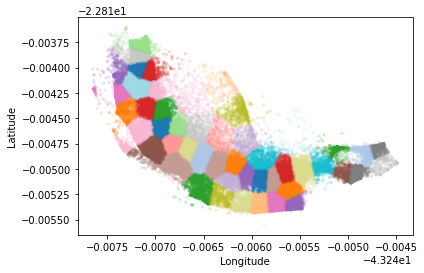

In [99]:
def plot_clusters(frame):
#     lng_border = (-43.247406, -43.245445)
#     lat_border = (-22.816297, -22.812845)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame.lng.values[:100000], frame.lat.values[:100000], s=10, lw=0,
               c=frame.cluster.values[:100000], cmap='tab20', alpha=0.2)
#     ax.set_xlim(lng_border)
#     ax.set_ylim(lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(df)

## create training and test set

In [585]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# X = StandardScaler().fit_transform(df[['lat','lng','bin','day_of_week','tag_1','cluster']])
X  = df[['lat','lng','bin','day_of_week','tag_1','cluster']]
y = df['tag_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))


2730625
682657


In [595]:
#extract month 9 for cv
sept = df[df.month == 9]
X_sept  = sept[['lat','lng','bin','day_of_week','tag_1','cluster']]
y_sept = sept['tag_2']
# sept.info()
X_sept.head()

lat        lng  bin  day_of_week  tag_1  cluster
768516 -22.814266 -43.247414   59            4      2       30
768518 -22.814202 -43.247331   90            4      2       30
768520 -22.815239 -43.245907   45            0      0        9
768522 -22.815401 -43.246201   56            0      0       43
768524 -22.815336 -43.246405   75            0      2       41

## Xgboost Cross-validation

In [105]:
# multiclass log_loss for socring
scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

estimator = XGBClassifier(
    objective= 'multi:softmax',
    num_class = 3,
    seed=42
)

parameters = {
    'max_depth': range (2, 8, 1),
    'n_estimators': range(60, 180, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = scorer,
    n_jobs = -1,
    cv = 5,
    verbose=True
)

grid_search.fit(X_sept, y_sept)



Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.7min
/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 27.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...t=None, seed=42, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': range(2, 8), 'n_estimators': range(60, 180, 40), 'learning_rate': [0.1, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
       verbose=True)

In [106]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

## Xgboost train with best params

In [24]:
xgb =XGBClassifier(
    objective= 'multi:softmax',
    num_class = 3,
    seed=42,
    learning_rate = 0.1,
    max_depth = 4,
    n_estimators = 100
)

xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=42, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [586]:
pred = xgb.predict(X_test)
classes = ['Eating', 'Shopping', 'Waiting']
print(classification_report(y_test, pred, target_names=classes))

              precision    recall  f1-score   support

      Eating       0.65      0.52      0.58    127770
    Shopping       0.57      0.45      0.50    205918
     Waiting       0.66      0.79      0.72    348969

    accuracy                           0.64    682657
   macro avg       0.63      0.59      0.60    682657
weighted avg       0.63      0.64      0.63    682657



## XGBoost confusion matrix

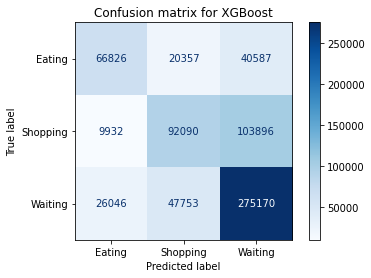

In [587]:

matrix = plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Blues,normalize= None,display_labels = classes,values_format = '.0f')
plt.title('Confusion matrix for XGBoost')
plt.show(matrix)
plt.show()


# LightGBM with Clustering

In [592]:
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'multiclass',
                         metric = 'multi_logloss',
                         verbose = 0,
                         learning_rate = 0.01,
                         num_leaves = 35,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0)
grid_search = GridSearchCV(gbm, param_grid=parameters, scoring='scorer', cv=5)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
print(grid_search.best_params_)


In [591]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',name='learning_rate')
dim_estimators = Integer(low=50, high=2000,name='n_estimators')
dim_max_depth = Integer(low=1, high=6,name='max_depth')

dimensions = [dim_learning_rate,
              dim_estimators,
              dim_max_depth]

default_parameters = [0.03,1000,3]

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clfs = []
importances = pd.DataFrame()

In [590]:
def createModel(learning_rate,n_estimators,max_depth):       

    oof_preds = np.zeros((len(X_train), len(classes)))
    for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
        trn_x, trn_y = X_train.iloc[trn_], y_train.iloc[trn_]
        val_x, val_y = X_train.iloc[val_], y_train.iloc[val_]

        clf = lgb.LGBMClassifier(**params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('fold',fold_+1,multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        clfs.append(clf)
    
    loss = multi_weighted_logloss(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % loss)
    
    return loss

In [589]:
params={
    'boosting_type': 'gbdt',
    'learning_rate':0.03,
    'metric': 'multi_logloss',
    'silent':True,
    'verbosity':-1,
    'nthread':-1,
    'is_unbalance': True,
    'max_depth':8,
    'objective':'multiclass',
    'n_estimators':400,
    'num_class':3,
    'num_iteration' : 500
}

train_data=lgb.Dataset(X_train,label=y_train)
validation_data=lgb.Dataset(X_test,label=y_test)
clf=lgb.train(params,train_data)
y_pred = clf.predict(X_test)
y_pred=[list(x).index(max(x)) for x in y_pred]

classes = ['Eating', 'Shopping', 'Waiting']
print(classification_report(y_test, y_pred, target_names=classes))

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


              precision    recall  f1-score   support

      Eating       0.72      0.57      0.64    127770
    Shopping       0.62      0.65      0.63    205918
     Waiting       0.73      0.77      0.75    348969

    accuracy                           0.69    682657
   macro avg       0.69      0.66      0.67    682657
weighted avg       0.70      0.69      0.69    682657



## LightGBM with clustering confusion matrix 

Confusion matrix, without normalization
[[ 73225  24207  30338]
 [  6243 133101  66574]
 [ 22301  58978 267690]]


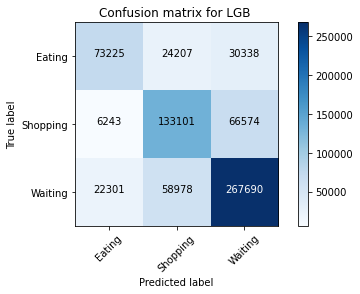

In [52]:

# matrix = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues,normalize='true',display_labels = classes)
# plt.title('Confusion matrix for our LGB classifier')
# plt.show(matrix)
# plt.show()
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix2(cnf_matrix, classes=classes,
                      title='Confusion matrix for LGB ')

plt.show()

## LightGBM with cluster removed

In [59]:
X  = df[['lat','lng','bin','day_of_week','tag_1']]
y = df['tag_2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
train_data=lgb.Dataset(X_train,label=y_train)
validation_data=lgb.Dataset(X_test,label=y_test)
lgb2=lgb.train(params,train_data)
y_pred = lgb2.predict(X_test)
y_pred=[list(x).index(max(x)) for x in y_pred]

classes = ['Eating', 'Shopping', 'Waiting']
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Eating       0.73      0.56      0.63    127770
    Shopping       0.61      0.64      0.63    205918
     Waiting       0.73      0.77      0.75    348969

    accuracy                           0.69    682657
   macro avg       0.69      0.66      0.67    682657
weighted avg       0.69      0.69      0.69    682657



# LightGBM without clustering confusion matrix 

Confusion matrix, without normalization
[[ 71602  24314  31854]
 [  5583 132187  68148]
 [ 21254  59354 268361]]


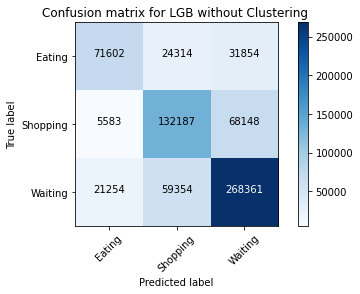

In [61]:
cnf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix2(cnf_matrix, classes=classes,
                      title='Confusion matrix for LGB without Clustering ')

plt.show()